# Seminar 3 Part 1: Tabular Q-Learning

In this seminar, we will consider the Cliff Walking problem, implement the tabular Q-learning algorithm and comparison with SARSA

The learning methods considered are based on backups which for dynamic programming, Monte Carlo, and temporal-difference learning can be represented as follows:

# The Cliff Walking problem

In this exercise, our goal is to implement and evaluate Q-learning algorithm for the Cliff Walking problem, and compare with SARSA.

The Cliff Walking problem is described in **Example 6.6** in Sutton & Barto.
 ![alt text](./graphs/cliff_walking.png)
- This is a standard undiscounted and episodic gridworld problem with starting and goal states
- Rewards of -1 for each move
- Stepping into the region marked "The Cliff" incurs a reward of -100 and sends the agent instantly back to the start state

The purpose of this example is to compare SARSA and Q-learning, highlighting the difference between on-policy (sarsa) and off-policy (Q-learning) methods. 

### The environment

In [1]:
class CliffWalking:
    def __init__(self, initial_state, goal_state):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False

    def is_cliff(self):
        cliff = np.zeros((world_height, world_width), dtype=bool)
        cliff[3, 1: -1] = True
        return cliff[tuple(self.state)]

    # return next_state, reward, done
    def step(self, action):
        i, j = self.state

        if action == up:
            self.state = [max(i - 1, 0), j]
        elif action == left:
            self.state = [i, max(j - 1, 0)]
        elif action == right:
            self.state = [i, min(j + 1, world_width - 1)]
        elif action == down:
            self.state = [min(i + 1, world_height - 1), j]
        else:
            assert False, "Actions should be in the range of (0, 4)"

        if self.is_cliff():
            self.state = self.initial_state
            self.reward = -100.0
            self.is_terminal = False
        elif self.state == self.goal_state:
            self.state = self.state
            self.reward = 0.0
            self.is_terminal = True
        else:
            self.reward = -1.0
            self.is_terminal = False
        return self.state, self.reward, self.is_terminal

    def reset(self):
        self.state = self.initial_state
        self.reward = 0.0
        self.is_terminal = False
        return self.state



A helper function to check if the current state is in the region of cliff,

In [2]:
def is_cliff(self):  
    cliff = np.zeros((world_height, world_width), dtype=np.bool)  
    cliff[3, 1: -1] = True  
    return cliff[tuple(self.state)]

### The Q-learning algorithm

<img src="./graphs/q_learning_algo.png" width="750" height="450">

Note that you need to pass all the state-action pairs of the next state,


In [3]:
def eps_greedy_policy(qsa, epsilon=0.1):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(actions)
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(qsa) if value_ == np.max(qsa)])

def sarsa(qsa, next_qsa, r, alpha=0.1, gamma=1.0):
    return qsa + alpha * (r + gamma * next_qsa - qsa)

def q_learning(qsa, next_qs, r, alpha=0.1, gamma=1.0):  
    return qsa + alpha * (r + gamma * np.max(next_qs) - qsa)

It is impossible to produce a smooth reward curve after a single run. We therefore take multiple runs and take the average of the rewards per episode over 500 episodes in total. 

In [4]:
start_position = [3, 0]  
goal = [3, 11]
world_width = 12
world_height = 4 
# actions
up = 0
left = 1
right = 2
down = 3
actions = [up, left, right, down]

In [5]:
import numpy as np
env_sarsa = CliffWalking(start_position, goal)
env_q_learning = CliffWalking(start_position, goal)

runs = 10
episodes = 500
rewards_sarsa = np.zeros(episodes)
rewards_qlearning = np.zeros_like(rewards_sarsa)

# Create two instances of the environments for comparison
env_sarsa = CliffWalking(start_position, goal)
env_q_learning = CliffWalking(start_position, goal)

for r in range(runs):
    q_sarsa = np.zeros((world_height, world_width, len(actions)))
    q_qlearning = np.zeros_like(q_sarsa)

    for i in range(episodes):
        state_sarsa = env_sarsa.reset()
        state_q = env_q_learning.reset()

        done_sarsa = False
        done_q = False

        # choose an action based on current state
        row, col = state_sarsa
        a_sarsa = eps_greedy_policy(q_sarsa[row, col, :])
        g_sarsa = 0.0
        g_q = 0.0
        
        #Sarsa
        while not done_sarsa:
            next_state_sarsa, r_sarsa, done_sarsa = env_sarsa.step(a_sarsa)
        
            # choose an action for the next state
            row, col = state_sarsa
            n_row, n_col = next_state_sarsa
            next_a_sarsa = eps_greedy_policy(q_sarsa[n_row, n_col, :])
            g_sarsa += r_sarsa
            # sarsa updates
            q_sarsa[row, col, a_sarsa] = sarsa(q_sarsa[row, col, a_sarsa], q_sarsa[n_row, n_col, next_a_sarsa], r_sarsa)

            state_sarsa = next_state_sarsa
            a_sarsa = next_a_sarsa
            
        #Q-Learning
        while not done_q:
            row_q, col_q = state_q
            a_q = eps_greedy_policy(q_qlearning[row_q, col_q, :])
            next_state_q, r_q, done_q = env_q_learning.step(a_q)
            g_q += r_q

            # Q-learning updates, note the second argument
            n_row_q, n_col_q = next_state_q
            q_qlearning[row_q, col_q, a_q] = q_learning(q_qlearning[row_q, col_q, a_q],
                                                        q_qlearning[n_row_q, n_col_q, :], r_q)
            state_q= next_state_q
            
        rewards_sarsa[i] += g_sarsa
        rewards_qlearning[i] += g_q

The comparison of the methods:

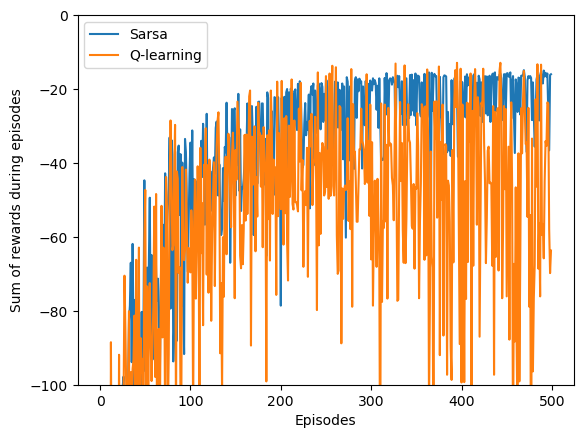

In [6]:
import matplotlib.pyplot as plt
def plot_rewards(plots):
    plt.figure()
    for plot in plots:
        method, method_title = plot
        plt.plot(method, label=method_title)
    # plt.plot(r_qlearning, label='Q-learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episodes')
    plt.ylim([-100, 0])
    plt.legend()
    plt.show()


rewards_sarsa /= runs
rewards_qlearning /= runs

plot_rewards([[rewards_sarsa, 'Sarsa'], [rewards_qlearning, 'Q-learning']])
#[rewards_double_qlearning, 'Double-Q-learning']])

The worse performance of Q-learning method is due to the $\varepsilon$-greedy policy which results in the agent's occasionally falling off the cliff when the method takes the optimal rather than safer path.

In [7]:
def print_optimal_policy(policy, method):
    policy_display = np.empty_like(policy, dtype=str)
    for i in range(0, world_height):
        for j in range(0, world_width):
            if [i, j] == [3, 11]:
                policy_display[i, j] = 'G'
                continue
            if i == 3 and j in np.arange(1,11): 
                policy_display[i, j] = 'C'
                continue
            a = policy[i, j]
            if a == up:
                policy_display[i, j] = 'U'
            elif a == left:
                policy_display[i, j] = 'L'
            elif a == right:
                policy_display[i, j] = 'R'
            elif a == down:
                policy_display[i, j] = 'D'
    print(method + ' Optimal policy is:')
    for row in policy_display:
        print(row)

optimal_policy = np.argmax(q_sarsa, axis=2)
print_optimal_policy(optimal_policy, 'SARSA')

optimal_policy = np.argmax(q_qlearning, axis=2)
print_optimal_policy(optimal_policy, 'Q-Learning')

SARSA Optimal policy is:
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D' 'R' 'R' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
['U' 'U' 'U' 'R' 'U' 'R' 'U' 'R' 'U' 'R' 'R' 'D']
['U' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']
Q-Learning Optimal policy is:
['R' 'U' 'D' 'R' 'R' 'R' 'R' 'L' 'D' 'R' 'D' 'D']
['R' 'R' 'R' 'R' 'R' 'D' 'R' 'R' 'D' 'R' 'D' 'D']
['R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'D']
['U' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'G']


Notice that SARSA identifies a safer path (the optimal path is not optimal here due to that the $\varepsilon$-greedy policy, which might force the agent to fall into the cliff when walking along the optimal path, yielding a low value)